# Fig1. Data and padding

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

import torch
from credit.boundary_padding import TensorPadding

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 1.5
#mpl.rcParams['hatch.linewidth'] = 1.0

### Load config

In [4]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [5]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

### Load land mask & apply padding

In [6]:
ds_static = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/static/ERA5_plevel_1deg_6h_subset_static.zarr'
)

ds_example = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/all_in_one/ERA5_plevel_1deg_6h_1979_conserve.zarr'
)

TSI = ds_example['toa_incident_solar_radiation'].isel(time=1).values
land_mask = ds_example['land_sea_CI_mask'].isel(time=1).values

grid_lat = ds_static['lat2d'].values
grid_lon = ds_static['lon2d'].values

GPH = ds_static['geopotential_at_surface'].values
soil_type = (7*ds_static['soil_type'].values).astype(int).astype(float)

GPH[soil_type==0] = np.nan
soil_type[soil_type==0] = np.nan

In [7]:
# land_mask = ds_static['land_sea_mask'].values
land_mask_pad = torch.from_numpy(land_mask[None, None, ])

padding_conf_earth = {'mode': 'earth', 
                      'pad_lat': [21, 22], 
                      'pad_lon': [44, 44]}
    

pad_opt = TensorPadding(**padding_conf_earth)
land_mask_pad = pad_opt.pad(land_mask_pad)
land_mask_pad = land_mask_pad.numpy().squeeze()

land_mask = np.flipud(land_mask)
land_mask_pad = np.flipud(land_mask_pad)

## Plot

In [8]:
grid_shape = land_mask.shape
grid_shape_pad = land_mask_pad.shape
fig_ratio = grid_shape_pad[0]/grid_shape_pad[1]

my_colors = gu.ksha_color_set_summon(color_set=0)
red = my_colors['red']
blue = my_colors['blue']

In [9]:
def fmt(x):
    if x == 0:
        return r"$0$"
    exponent = int(np.floor(np.log10(abs(x))))
    significand = x / 10**exponent
    if np.isclose(significand, 1.0):  # Special case for 1.0
        return r"$10^{{{}}}$".format(exponent)
    else:
        return r"${:.1f} \times 10^{{{}}}$".format(significand, exponent)

In [10]:
label_names = ['Coarse', 'Medium', 'Medium fine', 'Fine', 'Very fine', 'Organic', 'Tropical organic', 'Ocean']
cmap_GPH = cmaps.spread_15lev #precip2_17lev #spread_15lev #wind_17lev
cmap_SL = plt.cm.jet_r #tab10  #cmaps.WhViBlGrYeOrReWh_r

In [11]:
def combine_colormaps(cmap1, cmap2, name='CombinedColormap'):
    colors1 = cmap1(np.linspace(0, 1, 64))  # Take 128 colors from the first colormap
    colors2 = cmap2(np.linspace(0, 1, 128))  # Take 128 colors from the second colormap
    combined_colors = np.vstack((colors1, colors2))  # Stack them vertically
    return LinearSegmentedColormap.from_list(name, combined_colors)
    
cmap_ice = combine_colormaps(plt.cm.Blues_r, plt.cm.Greys)

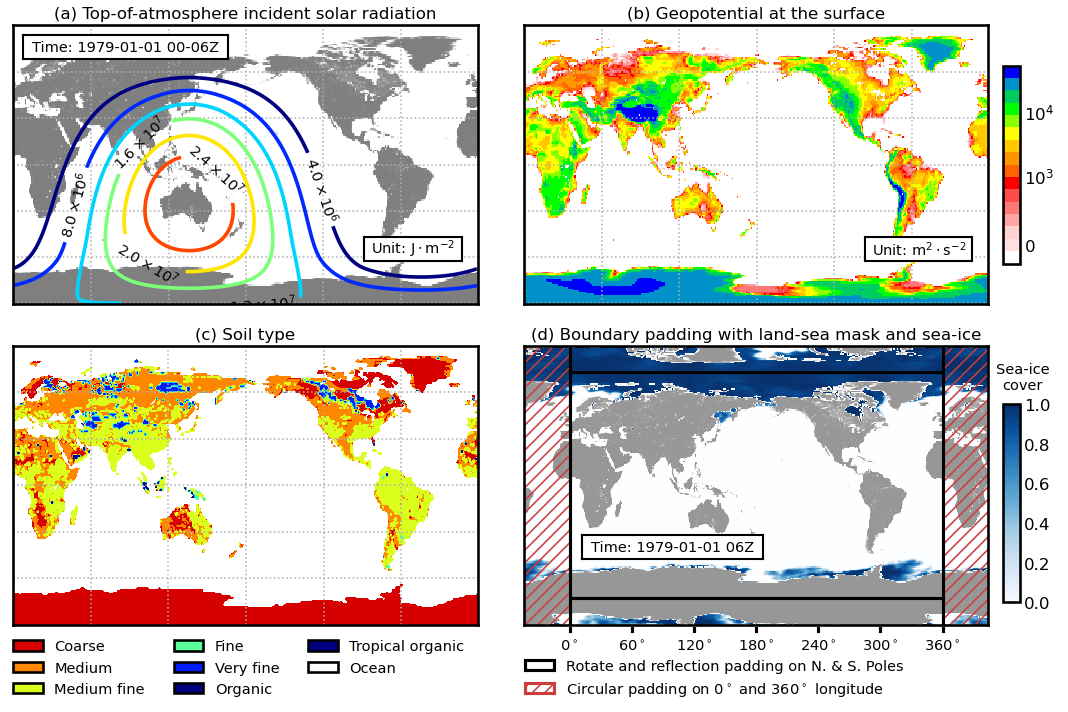

In [12]:
pad_y = [21, 22]
pad_x = 44
label_lon = np.arange(0, 360+60, 60)
label_lat = np.arange(-90, 90+30, 30)

TSI_levs = np.arange(0, 28000000+4000000, 4000000)
TSI_levs = TSI_levs[1:]

fig = plt.figure(figsize=(13, 8), dpi=dpi_)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

AX = []
AX.append(plt.subplot(gs[0, 0]))
AX.append(plt.subplot(gs[0, 1]))
AX.append(plt.subplot(gs[1, 0]))
AX.append(plt.subplot(gs[1, 1]))
plt.subplots_adjust(0, 0, 1, 1, hspace=0.15, wspace=0.1)

for ax in AX:
    ax = gu.ax_decorate_box(ax)
    ax.set_xticks(label_lon)
    ax.set_yticks(label_lat)
    
for ax in AX[:-1]:
    ax.grid(linestyle=':', linewidth=1.5)

# =============================================================================== #
# TSI

AX[0].pcolormesh(
    grid_lon, grid_lat, np.flipud(land_mask), vmin=0, vmax=2, cmap=plt.cm.gray_r
)

CS0 = AX[0].contour(
    grid_lon, grid_lat, TSI, levels=TSI_levs, linewidths=(3.5,), cmap=plt.cm.jet
)

formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-8, 8))
labels = AX[0].clabel(CS0, CS0.levels, fontsize=14, fmt=fmt)
for label in labels:
    label.set_color('k')
    
# =============================================================================== #
# GPH

CS1 = AX[1].pcolormesh(
    grid_lon, grid_lat, GPH, norm=colors.SymLogNorm(linthresh=1000), cmap=cmap_GPH
)

# =============================================================================== #
# soil type

CS2 = AX[2].contourf(
    grid_lon, grid_lat, soil_type, vmin=0.8, vmax=6, cmap=cmap_SL
)

# =============================================================================== #
# padding
ax = AX[3]
ax.pcolormesh(land_mask_pad, vmin=-1, vmax=2, cmap=cmap_ice)

patch_rec1 = patches.Rectangle((pad_x, 0), grid_shape[1], pad_y[1], 
                               linewidth=0, edgecolor=red, facecolor='none')
patch_rec2 = patches.Rectangle((pad_x, grid_shape_pad[0]-pad_y[0]), grid_shape[1], pad_y[0], 
                               linewidth=0, edgecolor=red, facecolor='none')
patch_rec3 = patches.Rectangle((0, 0), pad_x, grid_shape_pad[0], 
                               linewidth=0, edgecolor=red, facecolor='none', hatch='//')
patch_rec4 = patches.Rectangle((grid_shape_pad[1]-pad_x, 0), pad_x, grid_shape_pad[0], 
                               linewidth=0, edgecolor=red, facecolor='none', hatch='//')

ax.vlines(x=pad_x, ymin=0, ymax=grid_shape_pad[0], linewidth=3, linestyle='-', color='k')
ax.vlines(x=grid_shape_pad[1]-pad_x, ymin=0, ymax=grid_shape_pad[0], linewidth=3, linestyle='-', color='k')

ax.hlines(y=pad_y[1], xmin=pad_x, xmax=grid_shape_pad[1]-pad_x, linewidth=3, linestyle='-', color='k')
ax.hlines(y=grid_shape_pad[0]-pad_y[0], xmin=pad_x, xmax=grid_shape_pad[1]-pad_x, linewidth=3, linestyle='-', color='k')

ax_label1 = fig.add_axes([5.5/10.5, -0.0425, 5/10.5, 0.04])

loc_x = np.linspace(pad_x, grid_shape_pad[1]-pad_x, len(label_lon))/grid_shape_pad[1]

for i_label, lon in enumerate(label_lon):
    ax_label1.text(loc_x[i_label], 0.5, '{}$^\circ$'.format(lon), 
                   va='top', ha='center', fontsize=14, transform=ax_label1.transAxes)
    ax_label1.axvline(x=loc_x[i_label], ymin=0.8, ymax=1.0, linewidth=3, color='k')

# =============================================================================== #
# soil type legend
patch_colors = [pc.get_facecolor() for pc in CS2.legend_elements()[0]]

handle_lg1 = []
for pc in patch_colors:
    handle_lg1.append(patches.Patch(facecolor=pc, edgecolor='k', linewidth=2.5, label=''))

handle_lg1 = handle_lg1[:4] + handle_lg1[5:]

handle_lg1.append(patches.Patch(facecolor='w', edgecolor='k', linewidth=2.5, label=''))

ax_lg1 = fig.add_axes([0, -0.1325, 5/10.5, 0.13])
LG1 = ax_lg1.legend(handle_lg1, label_names, bbox_to_anchor=(1, 1), ncol=3, prop={'size':14})

# =============================================================================== #
# padding legend
handle_lg2 = []
handle_lg2.append(patches.Patch(linewidth=3, edgecolor='k', facecolor='none', label=''))
handle_lg2.append(patches.Patch(linewidth=3, edgecolor=red, facecolor='none', hatch='//', label=''))

ax_lg2 = fig.add_axes([5.5/10.5, -0.125, 5/10.5-0.0735, 0.09])
LG2 = ax_lg2.legend(handle_lg2, ['Rotate and reflection padding on N. & S. Poles', 
                                'Circular padding on 0$^\circ$ and 360$^\circ$ longitude',], 
                    bbox_to_anchor=(1, 1), ncol=1, prop={'size':14})


AX[0].set_title('(a) Top-of-atmosphere incident solar radiation', fontsize=16)
AX[1].set_title('(b) Geopotential at the surface', fontsize=16)
AX[2].set_title('(c) Soil type', fontsize=16)
AX[3].set_title('(d) Boundary padding with land-sea mask and sea-ice', fontsize=16)

# =============================================================================== #
# GPH colorbar
cbar_height = 0.5*(5/10.75-0.33)
ax_base1 = fig.add_axes([1.015, 5.75/10.75+cbar_height, 0.06, 0.33])
ax_base1.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1 = inset_axes(ax_base1, height='100%', width='30%', borderpad=0, loc=2)
CBar1 = plt.colorbar(CS1, orientation='vertical', cax=cax1)
CBar1.ax.tick_params(axis='y', labelsize=16, direction='in', length=0)
CBar1.outline.set_linewidth(2.5)

# GPH text
ax_base2 = fig.add_axes([5.5/10.5+0.35, 5.75/10.75+0.0725, 0.11, 0.04])
ax_base2.text(0.5, 0.5, 'Unit: $\mathsf{m^2 \cdot s^{-2}}$', 
              ha='center', va='center', fontsize=14, transform=ax_base2.transAxes)

# =============================================================================== #
# TSI text
ax_base3 = fig.add_axes([0+0.36, 5.75/10.75+0.0725, 0.1, 0.04])
ax_base3.text(0.5, 0.5, 'Unit: $\mathsf{J \cdot m^{-2}}$', 
              ha='center', va='center', fontsize=14, transform=ax_base3.transAxes)

ax_base4 = fig.add_axes([0+0.01, 5.75/10.75+0.4085, 0.21, 0.04])
ax_base4.text(0.5, 0.5, 'Time: 1979-01-01 00-06Z', 
              ha='center', va='center', fontsize=14, transform=ax_base4.transAxes)

# =============================================================================== #
# Sea-ice text
ax_base5 = fig.add_axes([5.5/10.5+0.06, 0+0.11, 0.185, 0.04])
ax_base5.text(0.5, 0.5, 'Time: 1979-01-01 06Z', 
              ha='center', va='center', fontsize=14, transform=ax_base5.transAxes)

# Sea-ice colorbar
cmap_ice_plot = plt.cm.Blues
CS_ice_plot = colors.Normalize(vmin=0, vmax=1)
ax_base6 = fig.add_axes([1.015, cbar_height-0.03, 0.06, 0.33])
ax_base2.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2 = inset_axes(ax_base6, height='100%', width='30%', borderpad=0, loc=2)
CBar2 = cbar.ColorbarBase(cax2, cmap=cmap_ice_plot, norm=CS_ice_plot, orientation='vertical')
CBar2.ax.tick_params(axis='y', labelsize=16, direction='in', length=0)
CBar2.outline.set_linewidth(2.5)

ax_base7 = fig.add_axes([1.015, cbar_height+0.33+0.03-0.03, 0.04, 0.03])
ax_base7.text(0.5, 0.5, 'Sea-ice\ncover', 
              ha='center', va='center', fontsize=14, transform=ax_base7.transAxes)

# ============================================================== #
# clean-up axes
ax.add_patch(patch_rec1)
ax.add_patch(patch_rec2)
ax.add_patch(patch_rec3)
ax.add_patch(patch_rec4)
ax_lg1.set_axis_off()
ax_lg2.set_axis_off()
ax_base1.set_axis_off()
ax_base6.set_axis_off()
ax_base7.set_axis_off()
ax_label1.set_axis_off()
gu.lg_clean(LG1)
gu.lg_clean(LG2)

for ax in [ax_base2, ax_base3, ax_base4, ax_base5]:
    ax.xaxis.set_tick_params(labelsize=0)
    ax.yaxis.set_tick_params(labelsize=0)
    [j.set_linewidth(2.0) for j in ax.spines.values()]
    
    ax.tick_params(
        axis="both", which="both", 
        bottom=False, top=False, 
        labelbottom=False, left=False, 
        right=False, labelleft=False
    )